In [2]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

!pip install visualkeras 
import visualkeras

try: 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.6.2


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync 
IMAGE_SIZE = [100, 100]
EPOCHS = 100 

In [4]:
train_folder= 'chest_xray/train/'
val_folder = '../input/chest-xray-pneumonia/chest_xray/val/'
test_folder = '../input/chest-xray-pneumonia/chest_xray/test/'

In [5]:
filepath = [] 
categories = [] 

In [6]:
filenames = os.listdir(os.path.join(train_folder,'NORMAL'))
for filename in filenames:
        filepath.append(os.path.join(train_folder,'NORMAL',filename))
        categories.append("NORMAL") #0: Normal

filenames = os.listdir(os.path.join(train_folder,'PNEUMONIA'))
for filename in filenames:
        filepath.append(os.path.join(train_folder,'PNEUMONIA',filename))
        categories.append("PNEUMONIA") #1: Pneumonia

In [7]:
filenames = os.listdir(os.path.join(val_folder,'NORMAL'))
for filename in filenames:
        filepath.append(os.path.join(val_folder,'NORMAL',filename))
        categories.append("NORMAL") #0: Normal
        
filenames = os.listdir(os.path.join(val_folder,'PNEUMONIA'))
for filename in filenames:
        filepath.append(os.path.join(val_folder,'PNEUMONIA',filename))
        categories.append("PNEUMONIA") #1: Pneumonia

Df Train-Vali:                                              filepath   label
0  ../input/chest-xray-pneumonia/chest_xray/train...  NORMAL
1  ../input/chest-xray-pneumonia/chest_xray/train...  NORMAL
2  ../input/chest-xray-pneumonia/chest_xray/train...  NORMAL
3  ../input/chest-xray-pneumonia/chest_xray/train...  NORMAL
4  ../input/chest-xray-pneumonia/chest_xray/train...  NORMAL

PNEUMONIA    3883
NORMAL       1349
Name: label, dtype: int64


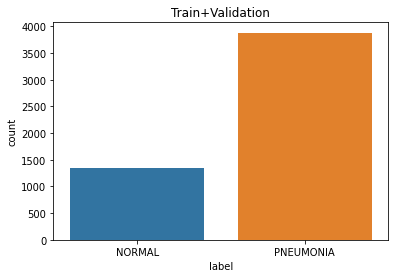

In [8]:
df = pd.DataFrame({'filepath':filepath,'label':categories})
df.info
plot = sns.countplot(x ='label', data = df).set_title('Train+Validation')
print("Df Train-Vali: ",df.head())
print("")
print(df['label'].value_counts())

In [9]:
train, vali = train_test_split(df, test_size=0.2,stratify=df['label'],random_state=6) #stratify to keep distribution

Train 80%: 
PNEUMONIA    3106
NORMAL       1079
Name: label, dtype: int64


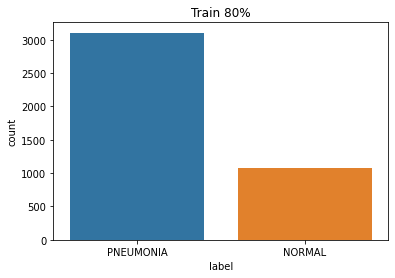

In [10]:
plot_train = sns.countplot(x ='label', data = train).set_title('Train 80%')
print('Train 80%: ')
print(train['label'].value_counts())

Validation 20%: 
PNEUMONIA    777
NORMAL       270
Name: label, dtype: int64


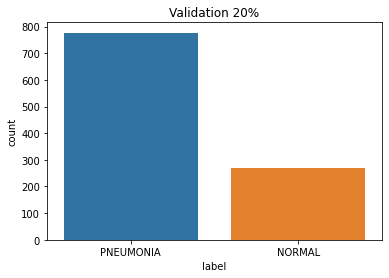

In [11]:
plot_vali = sns.countplot(x ='label', data = vali).set_title('Validation 20%')
print('Validation 20%: ')
print(vali['label'].value_counts())

In [12]:
load = ImageDataGenerator() 

In [13]:

train_set = load.flow_from_dataframe(train,
                                        x_col = 'filepath',
                                        y_col = 'label',
                                        target_size = IMAGE_SIZE,
                                        batch_size = BATCH_SIZE,
                                        class_mode = 'binary')

vali_set = load.flow_from_dataframe(vali,
                                        x_col = 'filepath',
                                        y_col = 'label',
                                        target_size = IMAGE_SIZE,
                                        batch_size = BATCH_SIZE,
                                        class_mode = 'binary')

test_set = load.flow_from_directory(test_folder,
                                        target_size = IMAGE_SIZE,
                                        batch_size = BATCH_SIZE,
                                        shuffle = False, #for confusionMatrix
                                        class_mode = 'binary')


print("train: ",train_set.class_indices)
print("vali: ",vali_set.class_indices)
print("test: ",test_set.class_indices)


Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.
train:  {'NORMAL': 0, 'PNEUMONIA': 1}
vali:  {'NORMAL': 0, 'PNEUMONIA': 1}
test:  {'NORMAL': 0, 'PNEUMONIA': 1}


In [14]:
VAL_IMG_COUNT = vali_set.samples
TEST_IMG_COUNT = test_set.samples

In [15]:
print('Train: ',Counter(train_set.classes))
print('Validation: ',Counter(vali_set.classes))
print('Test: ',Counter(test_set.classes))

Train:  Counter({1: 3106, 0: 1079})
Validation:  Counter({1: 777, 0: 270})
Test:  Counter({1: 390, 0: 234})


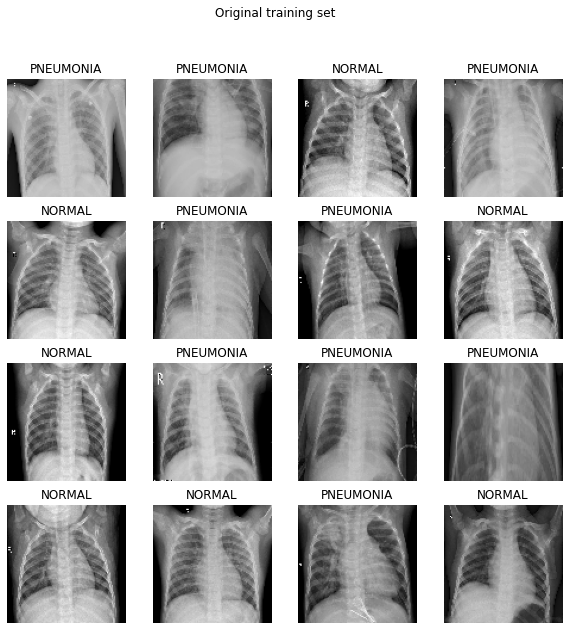

In [17]:
plt.figure(figsize=(10,10))
plt.suptitle('Original training set')
for n in range(16):
    ax = plt.subplot(4,4,n+1)
    plt.imshow(train_set[0][0][n].astype(np.uint8))  #uint8 to plot
    if train_set[0][1][n]:
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
    plt.axis("off")

In [18]:
augment_gen = ImageDataGenerator(zoom_range = 0.2,
                                   rotation_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   ) 

In [19]:
aug_train_set =  augment_gen.flow_from_dataframe(train,
                                        x_col = 'filepath',
                                        y_col = 'label',
                                        target_size = IMAGE_SIZE,
                                        batch_size = BATCH_SIZE,
                                        class_mode = 'binary')
print("\n Aug_train: ",train_set.class_indices)

Found 4185 validated image filenames belonging to 2 classes.

 Aug_train:  {'NORMAL': 0, 'PNEUMONIA': 1}


Plot some images of first batch of training set after data augmentation

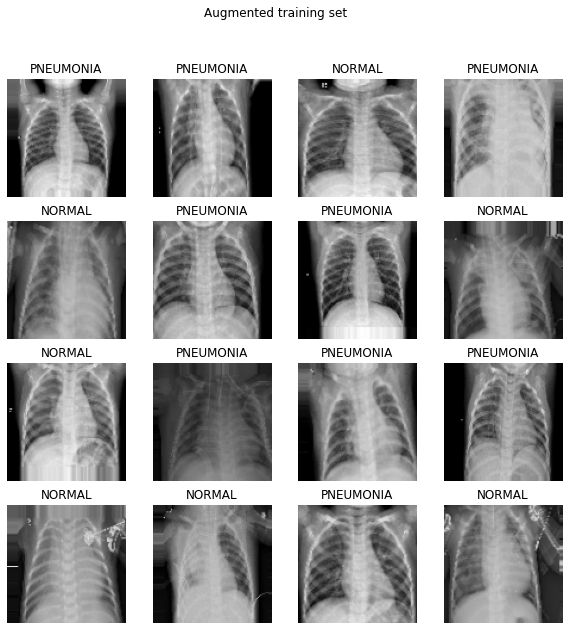

In [20]:
plt.figure(figsize=(10,10))
plt.suptitle('Augmented training set')
for n in range(16):
    ax = plt.subplot(4,4,n+1)
    plt.imshow(aug_train_set[0][0][n].astype(np.uint8))
    if train_set[0][1][n]:
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
    plt.axis("off")

Aug_train_set
NORMAL :  1079
PNEUMONIA :  3106


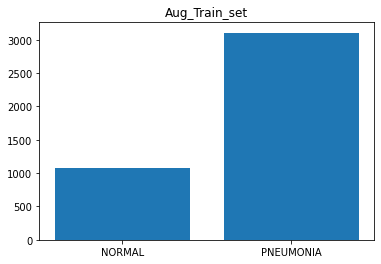

In [21]:
counter = Counter(aug_train_set.classes)
counter['NORMAL'] = counter.pop(0)
counter['PNEUMONIA'] = counter.pop(1) 

print('Aug_train_set')
for i in counter:
    print(i,': ',counter[i])

plt.bar(counter.keys(),counter.values())
plt.title('Aug_Train_set')
plt.show()

In [22]:
COUNT_PNEUMONIA=counter['PNEUMONIA']
COUNT_NORMAL=counter['NORMAL']
TRAIN_IMG_COUNT=aug_train_set.samples

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [23]:
keras.backend.clear_session() 

In [24]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [25]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [26]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Rescaling(scale=1./255), 
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2), 
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid') 
    ])

    return model

In [27]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
model.summary()

2022-09-21 09:40:58.833123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 09:40:58.973231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 09:40:58.974568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 09:40:58.981818: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 25, 25, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 12, 12, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 6, 6, 128)        

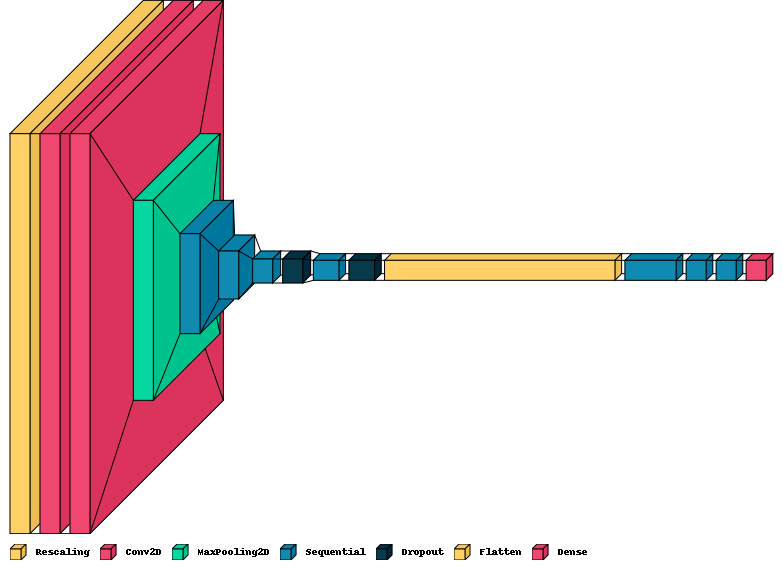

In [28]:
visualkeras.layered_view(model, legend=True)

In [29]:
print("steps_per_epoch : ",TRAIN_IMG_COUNT // BATCH_SIZE)
print("validation_steps : ",VAL_IMG_COUNT // BATCH_SIZE)

steps_per_epoch :  261
validation_steps :  65


In [30]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("CNN_xray_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=8,
                                                     restore_best_weights=True,verbose=1)#check val_loss

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001,verbose=1) 

In [31]:
history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb,early_stopping_cb,reduce_lr]
)

2022-09-21 09:41:03.156889: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-09-21 09:41:07.491994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


261/261 [==============================] - 124s 435ms/step - loss: 0.5101 - accuracy: 0.7469 - precision: 0.9263 - recall: 0.7157 - val_loss: 0.5879 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 0.58788, saving model to CNN_xray_model.h5
Epoch 2/100
261/261 [==============================] - 76s 290ms/step - loss: 0.3828 - accuracy: 0.8290 - precision: 0.9467 - recall: 0.8154 - val_loss: 0.5854 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000

Epoch 00002: val_loss improved from 0.58788 to 0.58541, saving model to CNN_xray_model.h5
Epoch 3/100
261/261 [==============================] - 74s 285ms/step - loss: 0.3302 - accuracy: 0.8561 - precision: 0.9578 - recall: 0.8432 - val_loss: 1.6231 - val_accuracy: 0.2635 - val_precision: 1.0000 - val_recall: 0.0052

Epoch 00003: val_loss did not improve from 0.58541
Epoch 4/100
261/261 [==============================] - 74s 284ms/step - loss: 0.2834 - accuracy: 

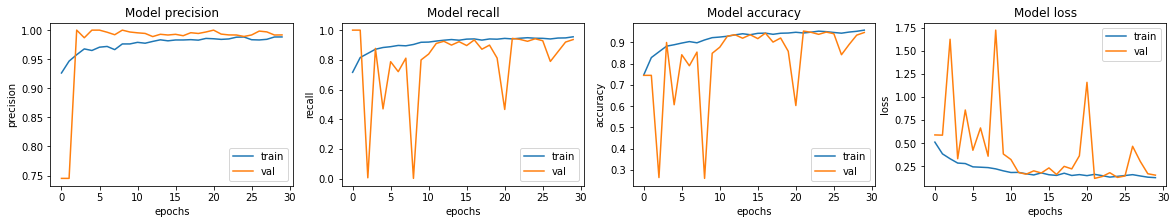

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
loss, acc, prec, rec = model.evaluate(test_set)

39/39 [==============================] - 10s 259ms/step - loss: 0.3047 - accuracy: 0.8974 - precision: 0.8705 - recall: 0.9821


In [35]:

predictions = model.predict(test_set)
predictions = predictions > 0.5


orig = test_set.labels

In [36]:
cm = confusion_matrix(orig, predictions)
print('Confusion matrix:')
print(cm)
print('')

cr = classification_report(orig, predictions)
print('Classification report:')
print(cr)
print('')

Confusion matrix:
[[177  57]
 [  7 383]]

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       234
           1       0.87      0.98      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.88       624
weighted avg       0.90      0.90      0.89       624




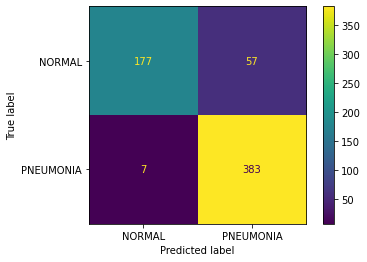

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NORMAL','PNEUMONIA'])
disp.plot()

errori commessi:  64


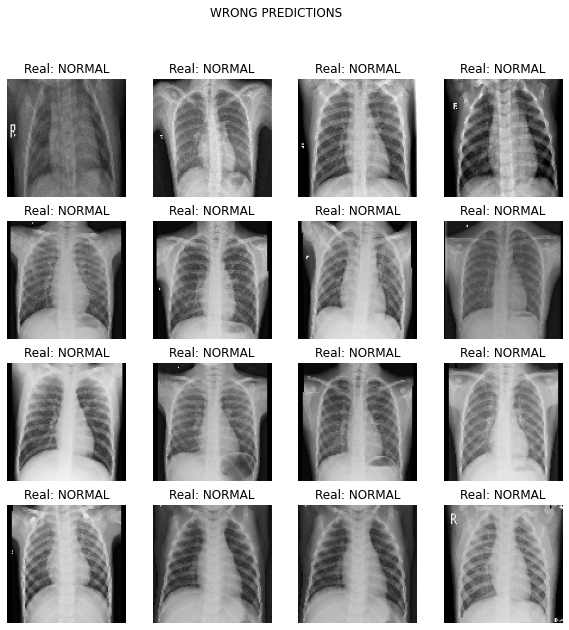

In [38]:
err=[i for i, (x, y) in enumerate(zip(predictions, orig)) if x != y] #check where orig and predictions don't match (wrong classification)

print('errori commessi: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): 
    bn=err[n]//BATCH_SIZE 
    ib=err[n]-BATCH_SIZE*bn 
   
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))
    
    if test_set[bn][1][ib]: 
        plt.title("Real: PNEUMONIA")
    else:
        plt.title("Real: NORMAL")
    plt.axis("off")

In [39]:
keras.backend.clear_session()

In [40]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False)  # Do not include the ImageNet classifier at the top

58900480/58889256 [==============================] - 0s 0us/step


In [41]:
base_model.trainable = False 

In [42]:
inputs = keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

x = tf.keras.applications.vgg16.preprocess_input(inputs)

x = base_model(x, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)  

outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 100, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [43]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=6,
                                                     restore_best_weights=True,verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-5 ,verbose=1) 

In [44]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)

Epoch 1/100
261/261 [==============================] - 75s 284ms/step - loss: 0.5907 - accuracy: 0.8638 - val_loss: 0.1791 - val_accuracy: 0.9365
Epoch 2/100
261/261 [==============================] - 73s 278ms/step - loss: 0.2412 - accuracy: 0.9081 - val_loss: 0.3439 - val_accuracy: 0.8952
Epoch 3/100
261/261 [==============================] - 72s 277ms/step - loss: 0.1869 - accuracy: 0.9242 - val_loss: 0.1903 - val_accuracy: 0.9317
Epoch 4/100
261/261 [==============================] - 72s 277ms/step - loss: 0.1779 - accuracy: 0.9297 - val_loss: 0.2192 - val_accuracy: 0.9250

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/100
261/261 [==============================] - 73s 282ms/step - loss: 0.1401 - accuracy: 0.9456 - val_loss: 0.3017 - val_accuracy: 0.9077
Epoch 6/100
261/261 [==============================] - 72s 277ms/step - loss: 0.1361 - accuracy: 0.9451 - val_loss: 0.2146 - val_accuracy: 0.9288
Epoch 7/100
261/261 [=====================

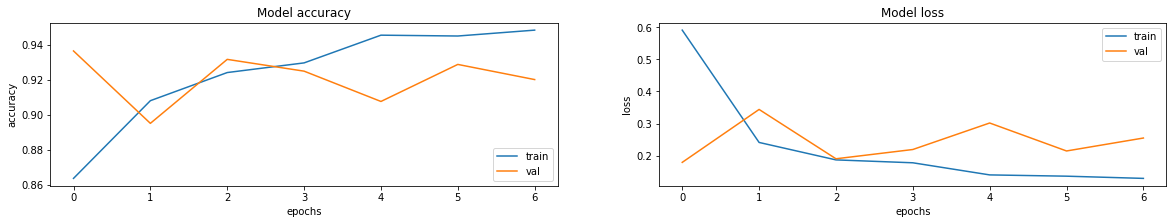

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [46]:

base_model.trainable = True

model.summary()

model.compile(optimizer=keras.optimizers.Adam(1e-5), #Very low learning rate
              loss='binary_crossentropy',
              metrics='accuracy')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 100, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [47]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("VGG16_xray_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1) 

In [48]:

history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb,early_stopping_cb]
)

Epoch 1/100
261/261 [==============================] - 76s 287ms/step - loss: 0.1946 - accuracy: 0.9292 - val_loss: 0.1690 - val_accuracy: 0.9433

Epoch 00001: val_loss improved from inf to 0.16900, saving model to VGG16_xray_model.h5
Epoch 2/100
261/261 [==============================] - 84s 322ms/step - loss: 0.1087 - accuracy: 0.9568 - val_loss: 0.1758 - val_accuracy: 0.9490

Epoch 00002: val_loss did not improve from 0.16900
Epoch 3/100
261/261 [==============================] - 76s 291ms/step - loss: 0.0814 - accuracy: 0.9703 - val_loss: 0.3370 - val_accuracy: 0.9029

Epoch 00004: val_loss did not improve from 0.16900
Epoch 5/100
261/261 [==============================] - 74s 284ms/step - loss: 0.0660 - accuracy: 0.9731 - val_loss: 0.1746 - val_accuracy: 0.9356

Epoch 00005: val_loss did not improve from 0.16900
Epoch 6/100
261/261 [==============================] - 74s 284ms/step - loss: 0.0703 - accuracy: 0.9729 - val_loss: 0.2008 - val_accuracy: 0.9308

Epoch 00006: val_loss di

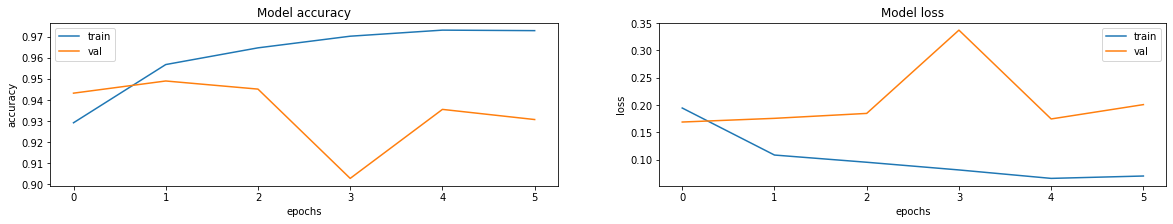

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [51]:
loss, acc = model.evaluate(test_set)

39/39 [==============================] - 6s 158ms/step - loss: 0.2061 - accuracy: 0.9247


In [52]:

predictions = model.predict(test_set)
predictions = predictions > 0.5

orig = test_set.labels

In [53]:
cm = confusion_matrix(orig, predictions)
print('Confusion matrix:')
print(cm)
print('')

cr = classification_report(orig, predictions)
print('Classification report:')
print(cr)
print('')

Confusion matrix:
[[202  32]
 [ 15 375]]

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.90       234
           1       0.92      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624




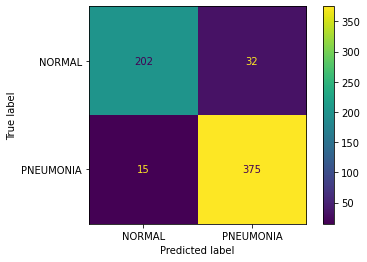

In [54]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NORMAL','PNEUMONIA'])
disp.plot()

errori commessi:  47


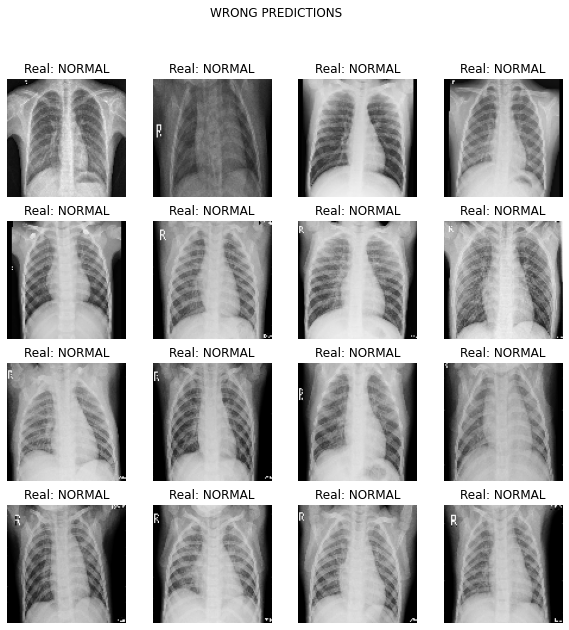

In [55]:
err=[i for i, (x, y) in enumerate(zip(predictions, orig)) if x != y] 

print('errori commessi: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): 
    bn=err[n]//BATCH_SIZE 
    ib=err[n]-BATCH_SIZE*bn 
    
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))  
    
    if test_set[bn][1][ib]: #real value
        plt.title("Real: PNEUMONIA")
    else:
        plt.title("Real: NORMAL")
    plt.axis("off")

In [56]:
keras.backend.clear_session()

In [57]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False)  

83697664/83683744 [==============================] - 1s 0us/step


In [58]:
base_model.trainable = False 

Crate new model on top and include preprocessing step for the input mages in the model

In [59]:
inputs = keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

x = tf.keras.applications.xception.preprocess_input(inputs)

x = base_model(x, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)  #
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 100, 100, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 100, 100, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [60]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=6,
                                                     restore_best_weights=True,verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-5 ,verbose=1) 

In [61]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)

Epoch 1/100
261/261 [==============================] - 77s 280ms/step - loss: 0.3661 - accuracy: 0.8352 - val_loss: 0.2272 - val_accuracy: 0.9115
Epoch 2/100
261/261 [==============================] - 72s 277ms/step - loss: 0.2607 - accuracy: 0.8858 - val_loss: 0.2525 - val_accuracy: 0.9019
Epoch 3/100
261/261 [==============================] - 73s 280ms/step - loss: 0.2498 - accuracy: 0.8829 - val_loss: 0.2602 - val_accuracy: 0.8981
Epoch 4/100
261/261 [==============================] - 73s 281ms/step - loss: 0.2327 - accuracy: 0.8988 - val_loss: 0.2475 - val_accuracy: 0.9077

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/100
261/261 [==============================] - 74s 283ms/step - loss: 0.2097 - accuracy: 0.9127 - val_loss: 0.2255 - val_accuracy: 0.9125
Epoch 6/100
261/261 [==============================] - 74s 282ms/step - loss: 0.1990 - accuracy: 0.9170 - val_loss: 0.2507 - val_accuracy: 0.8952
Epoch 7/100
261/261 [=====================

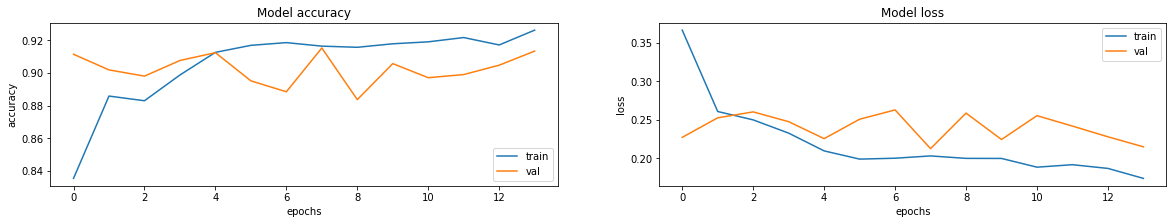

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [63]:

base_model.trainable = True

model.summary()

model.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss='binary_crossentropy',
              metrics='accuracy')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 100, 100, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 100, 100, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [64]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Xception_xray_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1) #check val_loss

In [65]:
history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb,early_stopping_cb]
)

Epoch 1/100
261/261 [==============================] - 83s 300ms/step - loss: 0.1683 - accuracy: 0.9319 - val_loss: 0.2293 - val_accuracy: 0.9202

Epoch 00001: val_loss improved from inf to 0.22925, saving model to Xception_xray_model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
261/261 [==============================] - 77s 294ms/step - loss: 0.1178 - accuracy: 0.9554 - val_loss: 0.2396 - val_accuracy: 0.9154

Epoch 00002: val_loss did not improve from 0.22925
Epoch 3/100
261/261 [==============================] - 77s 294ms/step - loss: 0.1021 - accuracy: 0.9599 - val_loss: 0.2466 - val_accuracy: 0.9144

Epoch 00003: val_loss did not improve from 0.22925
Epoch 4/100
261/261 [==============================] - 77s 296ms/step - loss: 0.0845 - accuracy: 0.9695 - val_loss: 0.2547 - val_accuracy: 0.9250

Epoch 00004: val_loss did not improve from 0.22925
Epoch 5/100
261/261 [==============================] - 77s 297ms/step - loss: 0.0825 - accuracy: 0.9655 - val_loss: 0.2030 - val_accuracy: 0.9365

Epoch 00005: val_loss improved from 0.22925 to 0.20297, saving model to Xception_xray_model.h5
Epoch 6/100
261/261 [==============================] - 77s 294ms/step - loss: 0.0677 - accuracy: 0.9760 - val_loss: 0.2804 - val_accuracy: 0.9192

Epoch 00006: val_

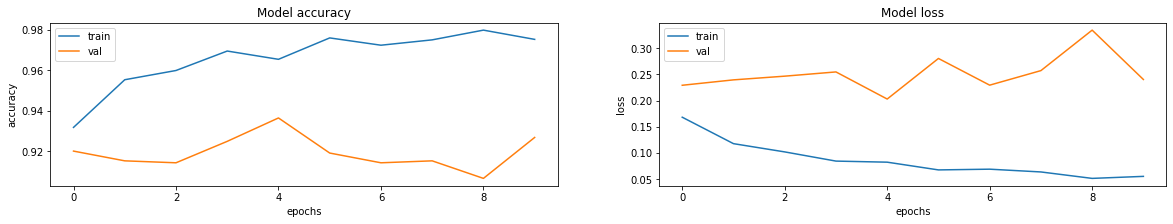

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [68]:
loss, acc = model.evaluate(test_set)

39/39 [==============================] - 8s 188ms/step - loss: 0.2481 - accuracy: 0.9215


In [69]:

predictions = model.predict(test_set)
predictions = predictions > 0.5

orig = test_set.labels

In [70]:
cm = confusion_matrix(orig, predictions)
print('Confusion matrix:')
print(cm)
print('')

cr = classification_report(orig, predictions)
print('Classification report:')
print(cr)
print('')

Confusion matrix:
[[197  37]
 [ 12 378]]

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       234
           1       0.91      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624




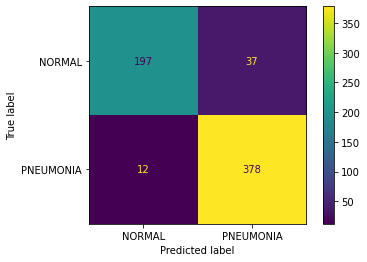

In [71]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NORMAL','PNEUMONIA'])
disp.plot()

errori commessi:  49


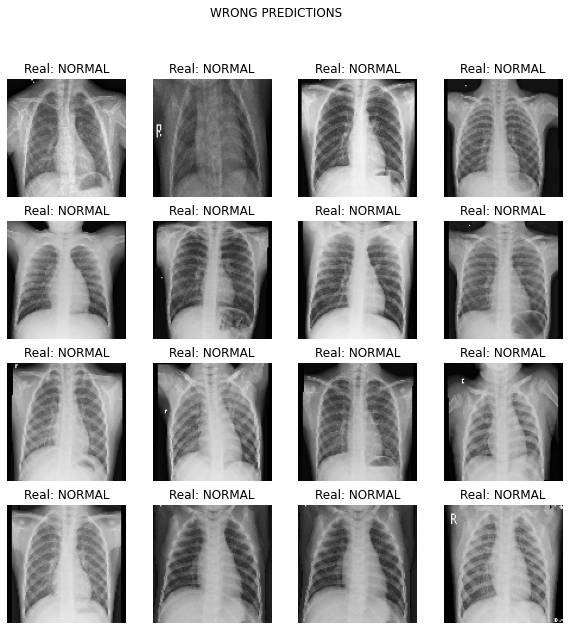

In [72]:
err=[i for i, (x, y) in enumerate(zip(predictions, orig)) if x != y] 
#print(err)
print('errori commessi: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): 
    bn=err[n]//BATCH_SIZE 
    ib=err[n]-BATCH_SIZE*bn 
    
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8)) 
    
    if test_set[bn][1][ib]: 
        plt.title("Real: PNEUMONIA")
    else:
        plt.title("Real: NORMAL")
    plt.axis("off")

In [73]:
keras.backend.clear_session()

In [74]:
base_model = keras.applications.ResNet152V2(
    weights='imagenet',  
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False)  

234561536/234545216 [==============================] - 1s 0us/step


In [75]:
base_model.trainable = False 

In [76]:
inputs = keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

x = tf.keras.applications.resnet_v2.preprocess_input(inputs)

x = base_model(x, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)  

outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 100, 100, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 100, 100, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 4, 4, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [77]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=6,
                                                     restore_best_weights=True,verbose=1)#check val_loss

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-5 ,verbose=1) #min_lr as input for fine tuning next

In [78]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)

Epoch 1/100
261/261 [==============================] - 89s 307ms/step - loss: 0.3689 - accuracy: 0.8573 - val_loss: 0.3355 - val_accuracy: 0.8654
Epoch 2/100
261/261 [==============================] - 77s 296ms/step - loss: 0.2404 - accuracy: 0.8981 - val_loss: 0.2638 - val_accuracy: 0.8942
Epoch 3/100
261/261 [==============================] - 77s 294ms/step - loss: 0.2263 - accuracy: 0.9057 - val_loss: 0.2190 - val_accuracy: 0.9202
Epoch 4/100
261/261 [==============================] - 77s 295ms/step - loss: 0.2085 - accuracy: 0.9117 - val_loss: 0.3118 - val_accuracy: 0.8885
Epoch 5/100
261/261 [==============================] - 77s 294ms/step - loss: 0.2045 - accuracy: 0.9156 - val_loss: 0.2572 - val_accuracy: 0.9048
Epoch 6/100
261/261 [==============================] - 76s 290ms/step - loss: 0.1866 - accuracy: 0.9242 - val_loss: 0.2016 - val_accuracy: 0.9231
Epoch 7/100
261/261 [==============================] - 75s 288ms/step - loss: 0.1916 - accuracy: 0.9175 - val_loss: 0.1988 -

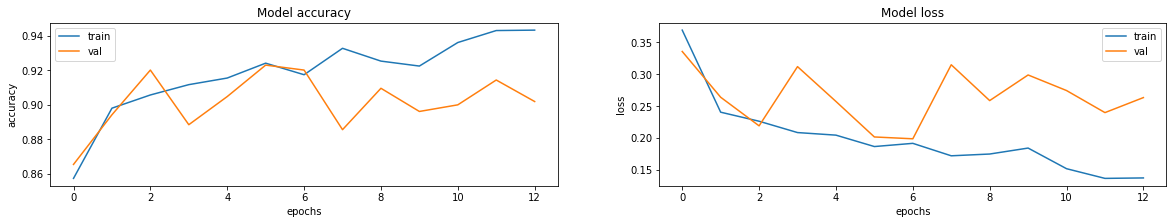

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [80]:

base_model.trainable = True

model.summary()

model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss='binary_crossentropy',
              metrics='accuracy')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 100, 100, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 100, 100, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 4, 4, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [81]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ResNet152V2_xray_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1)#check val_loss

In [82]:
history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb,early_stopping_cb]
)

Epoch 1/100
261/261 [==============================] - 105s 341ms/step - loss: 0.1627 - accuracy: 0.9324 - val_loss: 0.2010 - val_accuracy: 0.9202

Epoch 00001: val_loss improved from inf to 0.20100, saving model to ResNet152V2_xray_model.h5
Epoch 2/100
261/261 [==============================] - 85s 326ms/step - loss: 0.1021 - accuracy: 0.9587 - val_loss: 0.0926 - val_accuracy: 0.9587

Epoch 00002: val_loss improved from 0.20100 to 0.09264, saving model to ResNet152V2_xray_model.h5
Epoch 3/100
261/261 [==============================] - 84s 324ms/step - loss: 0.0885 - accuracy: 0.9693 - val_loss: 0.2240 - val_accuracy: 0.9279

Epoch 00003: val_loss did not improve from 0.09264
Epoch 4/100
261/261 [==============================] - 85s 324ms/step - loss: 0.0774 - accuracy: 0.9695 - val_loss: 0.1133 - val_accuracy: 0.9529

Epoch 00004: val_loss did not improve from 0.09264
Epoch 5/100
261/261 [==============================] - 84s 322ms/step - loss: 0.0825 - accuracy: 0.9671 - val_loss: 0

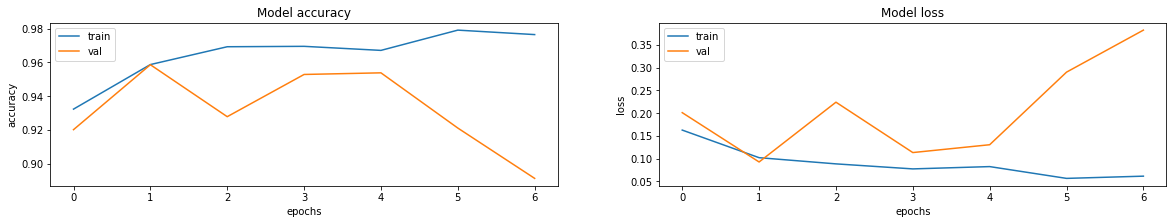

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [85]:
loss, acc = model.evaluate(test_set)

39/39 [==============================] - 7s 180ms/step - loss: 0.5446 - accuracy: 0.8734


In [86]:

predictions = model.predict(test_set)
predictions = predictions > 0.5


orig = test_set.labels

In [87]:
cm = confusion_matrix(orig, predictions)
print('Confusion matrix:')
print(cm)
print('')

cr = classification_report(orig, predictions)
print('Classification report:')
print(cr)
print('')

Confusion matrix:
[[165  69]
 [ 10 380]]

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81       234
           1       0.85      0.97      0.91       390

    accuracy                           0.87       624
   macro avg       0.89      0.84      0.86       624
weighted avg       0.88      0.87      0.87       624




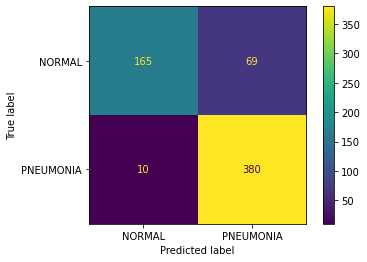

In [88]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NORMAL','PNEUMONIA'])
disp.plot()

errori commessi:  79


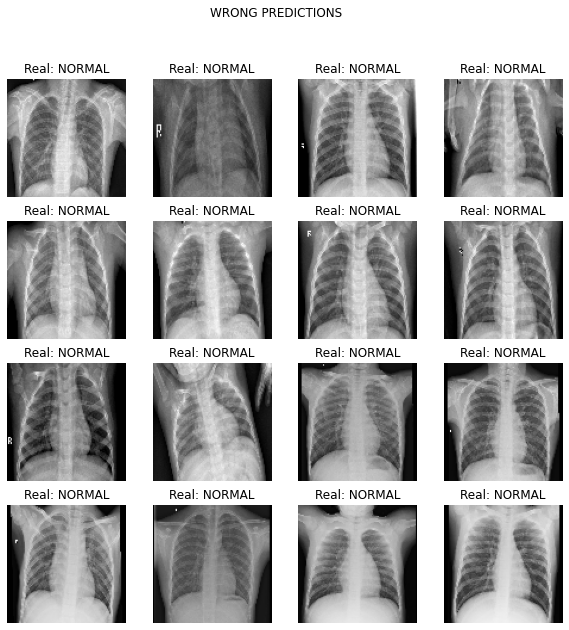

In [89]:
err=[i for i, (x, y) in enumerate(zip(predictions, orig)) if x != y] 
print('errori commessi: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): 
    bn=err[n]//BATCH_SIZE 
    ib=err[n]-BATCH_SIZE*bn 
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))  
    
    if test_set[bn][1][ib]==1: 
        plt.title("Real: PNEUMONIA")
    else:
        plt.title("Real: NORMAL")
    plt.axis("off")